Final Project Report - Data Exploration, Modeling, and Interpretation

SUMMARY

This project focused on the ASL RGB & Depth image dataset. This data set included American Sign Language signs from five individuals. The set included signs for all letters of the English alphabet excluding “j” and “z” as these require motion that was not possible to capture in a still image. My personal goal of the project was to train a model using deep learning methods that would classify an inputted image as one of the 24 letters available.

MOTIVATION

The overall motivation for creating this dataset is the fact that it could potentially be used as a tool for anyone who relies on sign language to communicate. Although small projects such as these may not reach those who would benefit from the end product, the importance of using science and technology for the good of the community will develop a mindset within the STEM community that pushes for a smarter, safer, and more user friendly world.


The method I intended to complete this project was to leverage the available tools within keras and tensorflow to train an image classification model. This proved to be a challenging task that required a few restarts.

OUTCOME


The initial model was developed from a pre-trained model that was intended for much bigger datasets than the one currently used. The MobileNetV2. This model was developed by google and had been previously trained on an enormous amount of data. Due to inexperience working with models I failed to account for overfitting the model as the data set used was relatively small. This resulted in 100% accuracy while training and low values while testing. This method was scrapped and the process began again after the presentation as I learned a lot about properly structuring a machine learning pipeline.

This next attempt started again with the data processing. My goal was to use a transfer learning method using a pytorch based library, FastAI. Knowing the model I would train in advanced allowed me to tailor the data processing to match the data structure that the model was built for. The bulk of the data processing was manipulating the tree structure of the data to fit standards used by the model. The data normalization and augmentation were handled by the FastAI methods.

The training process was much more straightforward after my first attempt with tensorflow, the feedback during the presentations, and the well written documentation for FastAI. The model developed from FastAI using resnet-18 is what was used to create an image classifier for the ASL dataset.

WEEKLY UPDATES

Weekly progress reports were made throughout the process. These reports are shown in the table below.



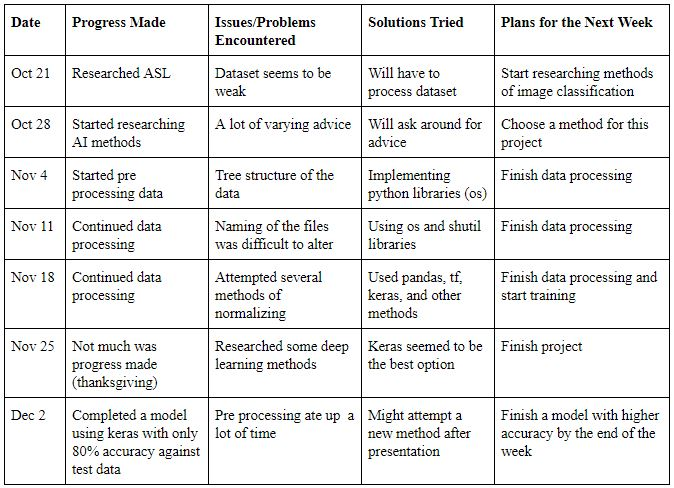

In [85]:
from IPython.display import Image
Image(filename='WeeklyUpdates.JPG') 

TECHNICAL INSTRUCTION

The first portion of this section gives some insight in the data processing that was completed. As mentioned before, the data set was represented by a tree like structure seperated by the individuals who created each sign image. This caused problems as the neural network was not suppose to be trained on the individuals who made the images, only the images themselves and the letter that they represent.

This called for data processing on the structure of the data set. Below are some methods used to rename and restructure the data. The bulk of the processing was done using the os and shutil modules as these work directly with the operating system directory. The goal of the processing was to shape the data to match image-net standards. Once the data was properly configured the rest of the data processing could be handled within the FastAI module.

In [38]:
from fastai.vision import *
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import re
import sys
import shutil
import imageio
import matplotlib.pyplot as plt
from PIL import Image 
from functools import reduce

In [39]:
# # Source path  
# source = "/home/dh225007904/ASLFinalProject/ASLFinalProject/ASLset/train/valid"
  
# # Destination path  
# destination = "/home/dh225007904/ASLFinalProject/ASLFinalProject/ASLset/valid"
  
# # Move the content of  
# # source to destination  
# dest = shutil.move(source, destination) 

# dataset_url = 'www.cvssp.org/FingerSpellingKinect2011/fingerspelling5.tar.bz2'
# filename = 'fingerspelling5.tar.bz2'
# # Data directory
# final_data_dir = 'ASLFinalProject/ASLset'
# # Data's top-level directory (after download & decompreshion)
# dataset_dir = '/home/dh225007904/ASLFinalProject/ASLset/asl-rgb-depth-fingerspelling-spelling-it-out'
# # Filename for image sizes
# img_sizes_csv = 'image_sizes.csv'

# # Link to dataset and 
# os.system('wget {URL}'.format(URL=dataset_url))

# # Uncompress
# os.system('tar xjf {}'.format(filename))

# for filename in os.listdir(path):
#     src = path+ '{}'.format(filename)
#     dest = moveto
#     if filename.startswith("depth"):
#         shutil.move(src,dest)

# path = "/home/dh225007904/ASLFinalProject/setsByLetter/"
# for root, dirs, files, in os.walk(path):
#     print(os.getcwd())

# #move file if filename __
# for root, dirs, files, in os.walk(path):
#     for filename in files:
#         if filename.startswith("depth"):
#             shutil.move(os.path.join(root, filename),moveto)

# #pulled out files from A, B, C... then renamed sequentially
# path = "/home/dh225007904/ASLFinalProject/setsByLetter/{}_sets/"

# i = 0
# for root, dirs, files, in os.walk(path):
#     for filename in files:
#         dst = "{}"+str(i)+".png"
#         src = os.path.join(root, filename)
#         dst = path+dst
#         os.rename(src,dst)
#         i += 1

In [40]:
path = "/home/dh225007904/ASLFinalProject/ASLFinalProject/ASLset/"

This is where the FastAI magic happens. In the next portion of the code the ImageDataBunch method is used. This method is used to pull in a data set and perform the formatting necessary to operate with a training mode. One parameter for this function is "tfms", short for transformations. This is where the rest of the data processing lives. By default FastAI will perform data normalization and data augmentation. As shown below some extra parameters needed to be set to create boundaries for the data augmentation. For example, since the images are of signed letter, we do not want the images to be flipped across any axis. There are additional bounds put in place to ensure that the images do not overextend in any warp or rotation during the data augmentation. The method below also takes care of the test and train sets. The data was initially seperated into these sets and FastAi will ensure that the data is randomly selected and split among these folders.

In [41]:
tfms = get_transforms(do_flip=False, max_rotate=10, max_zoom=1.1, max_lighting=0.3, max_warp=0.2)

data = (ImageDataBunch.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms)
        .databunch())

The next step in the process is to normalize the data to ensure there are no outliers within the data set that may skew the training. After the data was normalized some sample of the remaining processed images are shown to give an indea of the stage the images are in.

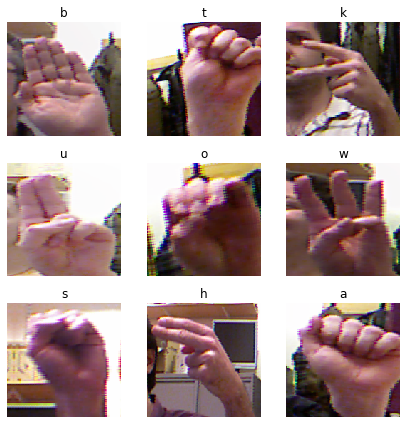

In [42]:
data.normalize()
data.show_batch(rows=3, figsize=(6,6))

After the data pre-processing was completed the next step was to train the model. I decided to take a transfer learning approach and use a pretrained model. This improves accuracy and reduces time necessary to train an extensive model such as this one. The method below downloads a specified model that will be used for the dataset. Resnet-18 was chosen for its success in image classification and ease of use within FastAi.

The transfer learning method works by deleted or freezing two layers of the network. The last layer is deleted and replaced by a new layer, this layer is the head. The head is replaced as this layer has learned a large amount about previous dataset features and may try to apply these to your dataset. To prevent this bias, the layer is refreshed. Additionally, the initial layer of the model is frozen to prevent the weighted routes to effect the training.

In [43]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dh225007904/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.9MB/s]


In [44]:
data.classes

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y']

Once the model was created and fitted to the data set provided I began to train it. The method below used the fit_one_cycle functionality that adjusts the learning rate of the training as time progresses. The model was trained for an initial 4 epochs and vast improvement was made. Below is a table showing the progression of loss and accuracy as the epochs increase. All together these 4 epochs lasted about 20 minutes total. The accuracy rose from 87 to 98 percent on the inital test set.

In [46]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.845343,0.387175,0.871205,04:27
1,0.334958,0.131280,0.953494,04:31
2,0.176215,0.060126,0.980241,04:32
3,0.131820,0.045722,0.985904,04:27


Although the model gave decent results during the testing process, the model can always be improved to read data from an outside souce. Below is the unfreeze method and the lr_find method. The model has been pre-trained and initialized with a refeshed final layer and an opened weight dataset. The next step was to identify the ideal leanning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


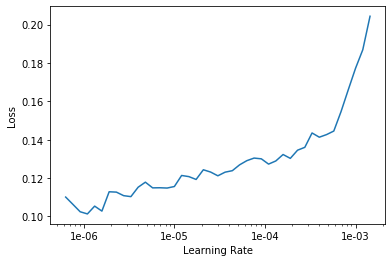

In [47]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

The ideal learning rate is said to be the portion of the graph with the steepest downward slope. Additionally, the ideal lr should be left of the lowest point on the graph. From this we can estimate that the ideal learning rate in this situation is about 8e-07. We will determine the slice to be from 7e-7 to 1e-6.

In [49]:
learner.fit_one_cycle(4, max_lr=slice(7e-7, 1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.138118,0.042288,0.986988,06:10
1,0.124395,0.037758,0.988554,06:16
2,0.112945,0.036103,0.988916,06:14
3,0.121541,0.036240,0.988916,06:10


In [50]:
learner.save('asl-classifier-stage-1')

Once the learning rate was chosen the model was retrained with new parameters resulting in higher accuracy.

In [54]:
interp = ClassificationInterpretation.from_learner(learner)

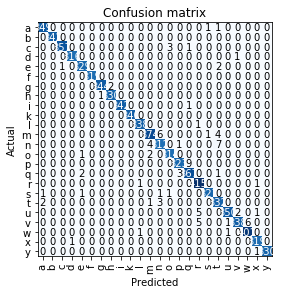

In [55]:
interp.plot_confusion_matrix()

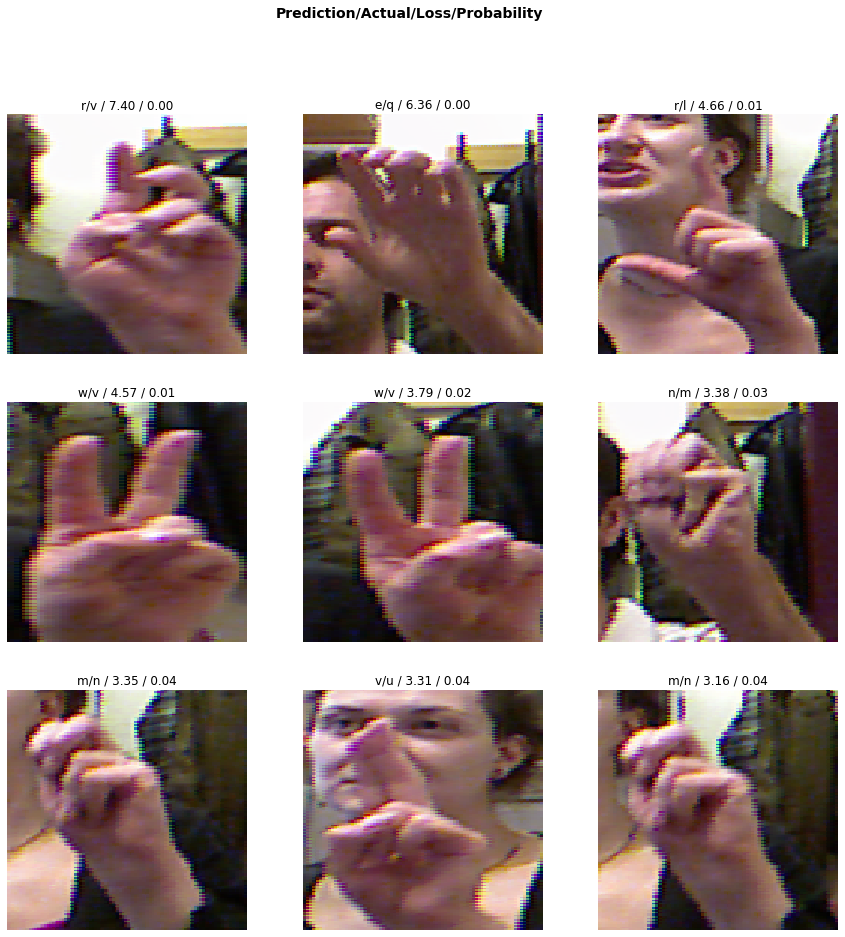

In [56]:
interp.plot_top_losses(9, figsize=(15,15))

In [90]:
img = learner.data.train_ds[0][0]
learner.predict(img)

(Category t,
 tensor(18),
 tensor([1.9345e-04, 7.8477e-09, 1.0412e-07, 2.6302e-06, 2.4894e-04, 4.3088e-09,
         2.2891e-06, 1.2400e-07, 3.4419e-08, 9.8803e-08, 1.4188e-06, 9.0761e-05,
         5.5593e-02, 1.2508e-06, 1.5293e-05, 4.0235e-07, 6.3985e-06, 1.6313e-05,
         9.4201e-01, 8.0852e-07, 1.4710e-07, 3.0303e-09, 1.8173e-03, 2.8266e-07]))

In [61]:
learner.export()

The model ended with good results. As shown wbove however, some common mislabelled letters were m and n, and v and u. The model reached as high as 98.9% accuracy on the validation set. This left me satisfied but I wanted real implementation of the model. This lead to an attempt to host the model on a cloud web app page. This turned out to be a longer process than expected. Until then, there is not any test on my own personal images or any images outside of the database. I tend to continue working on the web app so that others can upload their own images from their desktop or mobile device and see if the model does its job.

CONCLUSION

In the end the model was able to perform well when put agianst its own testing data. I am still curious in how the actual prediction of new data would work out with the new data augmentation that was implemented. I will most likely push this code to my github and continue to work on the web app. Hopefully then I will be able to see how well the model is. Overall I am proud of what I was able to accomplish and the new gained knowledge I obtained during the process. This project taught me both techincal and analytical skills that I will continue to use throughout my life while working with technology.

In [91]:
pip freeze

absl-py==0.8.1
alembic==1.2.1
amqp==2.5.1
ase==3.18.1
asn1crypto==0.24.0
astor==0.8.0
astroid==2.3.2
astropy==3.2.2
async-generator==1.10
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
backcall==0.1.0
beautifulsoup4==4.8.1
billiard==3.6.1.0
bleach==3.1.0
blis==0.4.1
blivet==3.1.0
Bottleneck==1.2.1
brewer2mpl==1.4.1
Brlapi==0.6.7
celery==4.3.0
certifi==2019.9.11
certipy==0.1.3
cffi==1.11.5
chardet==3.0.4
Click==7.0
click-plugins==1.1.1
cliff==2.8.3
cligj==0.5.0
cmd2==0.9.19
colorama==0.4.1
configobj==5.0.6
configparser==4.0.2
confuse==1.0.0
coverage==4.5.1
cryptography==2.3
cssselect==1.0.3
cupshelpers==1.0
cycler==0.10.0
cymem==2.0.2
dask==2.7.0
dataclasses==0.7
decorator==4.4.0
defusedxml==0.6.0
describe==0.1.2
dill==0.3.1.1
Django==2.2.5
dscribe==0.2.9
entrypoints==0.3
eyeD3==0.8.10
fastai==1.0.59
fastprogress==0.1.21
file-magic==0.3.0
findspark==1.3.0
Fiona==1.8.8
future==0.18.1
gast==0.2.2
geopandas==0.6.0
ggplot==0.11.5
google-pasta==0.1.7
googleapis-common-protos==1.6.0
gpg==